# Workshop 7
## **Unsupervised Machine Learning**

There are three sections to this notebook:
1) Imports + loading and pre-processing a number of different datasets
2) General functions to apply unsupervised methods and display results
3) Application of the functions to the datasets and exploration of the results

Please skim through sections 1 and 2, but spent most time in section 3 where you are expected to modify the code to explore different methods and different datasets, to get an understanding of how the methods apply to a range of real (as well as some artificial) datasets.  This exploration is key to gaining a true understanding of how the methods can be applied in practice.

### The general flow
As a note, this workshop is a little different from the previous ones. Here there are several data sources being examined, so there is a lot more setup.

## **Section 1**

In [1]:
# Common imports
import sklearn
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
import pandas as pd
import seaborn as sns; sns.set()

# There are a lot of imports below but don't worry about them
#  you can easily figure out when you need them from the docs
#  you wouldn't be expect to know or remember these

# Datasets
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs

# Clustering methods
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture, manifold, random_projection
from scipy.cluster.hierarchy import dendrogram, linkage

# This is for reading some medical imaging formats
import nibabel as nib   

# Convenient variable for specifying colours throughout
global_palette = 'tab10'   

# Dependencies
It is likely that you should install nibabel. Use either:

!pip install nibabel

OR

conda install -c conda-forge nibabel

In [3]:
# Also, check the version of your threadpoolctl library. It should be greater than 3.0 to avoid problems
#import threadpoolctl
#threadpoolctl.__version__

# !pip install --upgrade threadpoolctl

### Initial loading and description
The following cells load in the data and show a small amount of info on them. A few mundane observations. What a lot of binary input data we have here... it looks like mostly 1's and 0's.

In [4]:
# Dictionary for all datasets - each entry to store (x, labels)
datasets={}

# Dataset on children with physical and motor disabilities
# https://archive.ics.uci.edu/ml/datasets/SCADI
data = pd.read_csv('SCADI.csv')

# We can check the first rows of our dataset
data.head(5)

,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-8,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9,Classes
0,0,18,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,class6
1,0,22,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,class6
2,0,18,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,class6
3,1,18,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,class6
4,0,19,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,class6


In [5]:
# We can extract the features
x = data.iloc[:,:-1].to_numpy(dtype=np.float64)
print(x.shape)

# Also, we can extract the labels
labels = data["Classes"].astype('category').cat.codes.to_numpy()

# We can put this dataset in the dictionary datasets, under the name "scadi"
datasets['scadi'] = (x, labels)

(70, 205)


### Histograms
Sometimes, going to that little bit of extra effort with your histogram makes all the difference. As a trick, whenever you have classes that are numbers 0:N, making your bins work at 0.5, 1.5 etc will ensure they are all labelled sensibly in the final diagram.

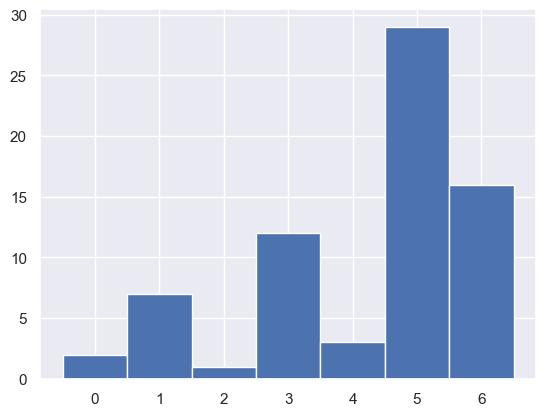

In [6]:
# Visualise the labels

unique_labels = np.unique(labels)
# plt.hist(labels)
plt.hist(labels, np.append(unique_labels, len(unique_labels)) - 0.5)
plt.show()

x_im shape: 207 256
(52992, 1)


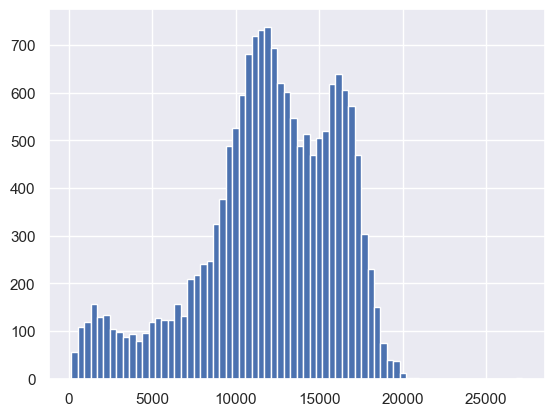

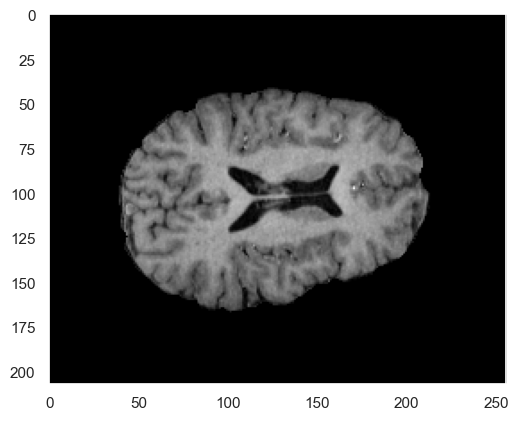

In [7]:
# Brain MRI image slice
im = nib.load('T1_brain.nii.gz').get_fdata()

# We can change this to have a look at different images in the dataset (default is 95)
image_selection = 95 

# We can extract one image
x_im = im[:,:,image_selection]

# This is an interesting step. The reality is, that the images are... images 
# but 2D arrays aren't always the format we need to use.

# Furthermore, why would we do this??
nx, ny = x_im.shape

print("x_im shape:", nx, ny)

# force it to be a 2D array with one column (consistent with other datasets)
x = x_im.reshape(-1,1)  
# Can go back to original 2D image (for display later on) with reshape((nx,ny))
labels = None

# We can put this dataset in the dictionary datasets, under the name "brain"
datasets['brain'] = (x, labels)
print(x.shape)

# Visualise data. Most values are 0, we remove these values to focus our analysis in the brain mass
plt.hist(x[x>0],70)
plt.show()

# Visualize one image
plt.imshow(x_im, cmap='gray')
plt.grid(None)
plt.show()

### Intepreting the Brain Tissue Figures
It should be noted, that the main point here is that we are looking at a variety of pixel values, and their intensities. As you can see from the histogram, it would appear that there are different peaks to the data. These correspond roughly to the type of tissue present in the brain. To give a bit of context, different regions of the brain, when run through (this looks like an fMRI to me) different scanners will have different densitities. You may have heard of white matter and grey matter? White matter refers to tracts (i.e. nerves) and is the connection between different brain cells. Grey matter is what really matters for 'thinking'. In different brain diseases the ratio or overall quantity of different types of brain matter is very important.

In [8]:
# Breast cancer data
data = load_breast_cancer()
x = data['data']
labels = data['target']

# We can put this dataset in the dictionary datasets, under the name "breast"
datasets['breast'] = (x, labels)
print(x.shape)

(569, 30)


In [9]:
# Classic Iris dataset
iris = load_iris()
x = iris.data
labels = iris.target

# We can put this dataset in the dictionary datasets, under the name "iris"
datasets['iris'] = (x, labels)
print(x.shape)

(150, 4)


In [10]:
# Interesting 2D data
data = np.load('clusterable_data.npy')
x = data
labels = None

# We can put this dataset in the dictionary datasets, under the name "interesting"
datasets['interesting'] = (x, labels)
print(x.shape)

(2309, 2)


In [11]:
# Artificial dataset
blobs = make_blobs(n_samples=200, centers=4, n_features=3, random_state=42)
x = blobs[0]
labels = blobs[1]

# We can put this sintethic dataset in the dictionary datasets, under the name "artificial"
datasets['artificial'] = (x, labels)
print(x.shape)

(200, 3)


### Apply scaling to the data

The reasoning behind this weird dictionary of different datasets becomes more apparent when we can now apply several pre-processing steps to multiple datasets with ease.

In [12]:
# Mean centre and variance scale all datasets independently
for key in datasets:
    x, labels = datasets[key]
    x = StandardScaler().fit_transform(x)
    datasets[key] = (x, labels)

# Size and Shape
Data is always much easier to interpret when you know the shape of it. Do I have 10 labels, or 200? Or None?

It is a good point to stop and think... why on earth would I have... no labels? (There is a very straightforward answer)

In [13]:
# We can see our dataset
for key in datasets:
    if datasets[key][1] is None:
        print(f'{key}: shape = {datasets[key][0].shape} and labels = None')
    else:
        print(f'{key}: shape = {datasets[key][0].shape} and labels = {datasets[key][1].shape}')

scadi: shape = (70, 205) and labels = (70,)
brain: shape = (52992, 1) and labels = None
breast: shape = (569, 30) and labels = (569,)
iris: shape = (150, 4) and labels = (150,)
interesting: shape = (2309, 2) and labels = None
artificial: shape = (200, 3) and labels = (200,)


## **Section 2**

### Supporting functions for viewing data and some specific visualisations
It is often useful to automate display functions to suit your purpose. It is very common to need to plot the same 'type' of plot for either multiple different datasets or for different model runs (with different hyperparameters). Things as simple wrapping an existing plot function and adding a few default parameters and maybe titles and axis labels can make your figures far more professional and at the same time, easier to interpret with less coding... win-win.

In [14]:
# Define a function to visualize data using scatterplot
def view_data(x, labels, plotdimx=0, plotdimy=1):
    # View data (choose any two features)
    ax = sns.scatterplot(x=x[:,plotdimx], y=x[:,plotdimy], hue=labels, palette=global_palette)
    ax.set_title('Original data')
    plt.show()

In [15]:
# Define a function to visualize brain images
def view_brain_image(x, labels, nx, ny):
    im = x.reshape((nx,ny))
    imlab = labels.reshape((nx,ny))
    plt.imshow(im, cmap='gray')
    plt.grid(None)
    plt.show()
    plt.imshow(imlab, cmap='jet')
    plt.grid(None)
    plt.show()

In [16]:
# Define function to create dendogram
def view_dendrogram(x):
    # Hierarchical clustering
    # Calculate and show dendogram
    Z = linkage(x, 'ward')
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z)
    plt.gca().set_title('Dendrogram')
    plt.show()

In [17]:
# Applying PCA to data and visualize results
def view_pca(x):
    # PCA visualisation
    pca = PCA()  # find all components
    pca.fit(x)
    
    # show component vectors (weightings per feature)
    ax = plt.plot(pca.components_[0],'r.', markersize=20)
    plt.plot(pca.components_[1],'b.', markersize=20)
    plt.gca().set_title('PCA Component Weights')
    plt.legend(['PCA Arg[0]', 'PCA Arg[1]'])
    plt.show()
    
    evr = pca.explained_variance_ratio_

    total = evr * 0
    total[0] = evr[0]


    for count_c in range(1, evr.shape[0]):
        total[count_c] = total[count_c - 1] + evr[count_c]

    # show scree plot of explained variance (the "knee", if it exists, can indicate data dimensionality)
    plt.plot(evr)
    plt.plot(total, 'k-')
    plt.legend(('Contribution', 'Cumulative'))

    plt.gca().set_title('PCA Explained Variance')
    plt.show()

### Generic function for data visualisation
This can be used by many methods (most of the code is just for plotting)

In [18]:
# Generic function to apply transformation to data and visualize it
def visualisation(method, x, labels, plotdimx=0, plotdimy=1):
    # General Data Visualisation
    y = method.fit_transform(x)  # this line does all the work!
    # do some plots
    ax = sns.scatterplot(x=y[:,plotdimx], y=y[:,plotdimy], hue=labels, style=labels, palette=global_palette) #seaborn plotting routine
    ax.set_title('Data Visualisation (true labels set both colours and shapes)')
    plt.show()
    return None

## **Section 3**

### Below here is where you start making changes
Separate cells for exploring visualisation (first) and clustering (second)

Also see suggested list of things to do after these cells

### Visualisation and dimensionality reduction
Apply some visualisation methods

Note that many of these can also be used for dimensionality reduction

Think about the attributes of a dataset that allow the different methods, incl. PCA and dendrogram, to work correctly (or note errors that indicate this)

Simple visualization using two features


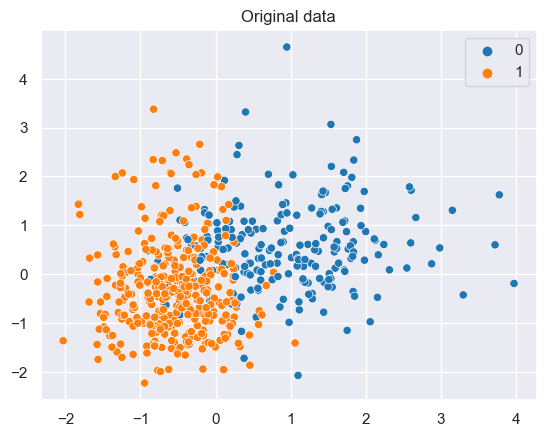

Dendogram visualization


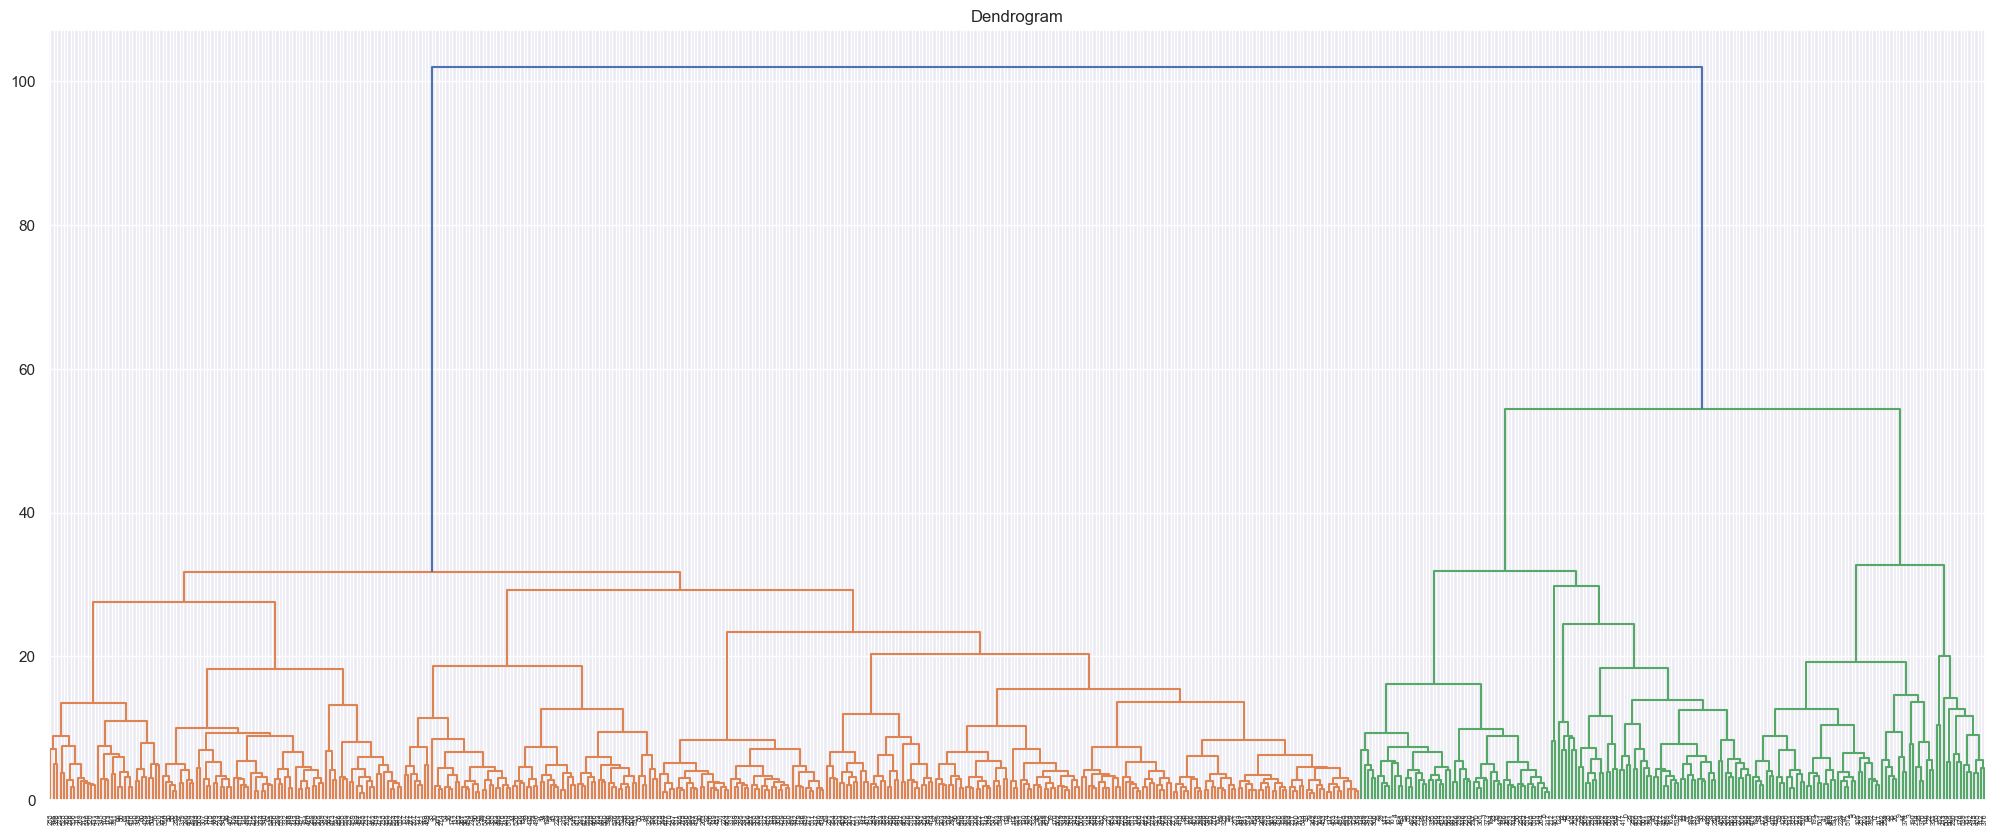

Getting PCA features


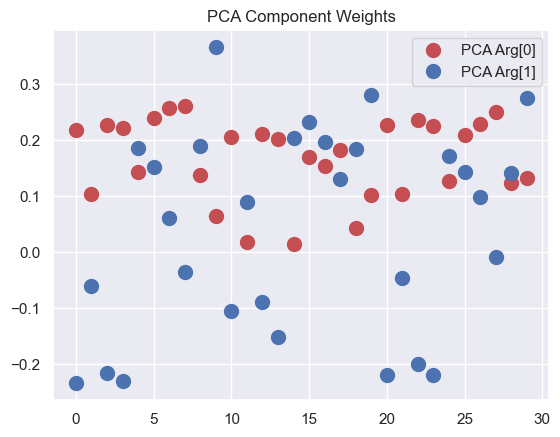

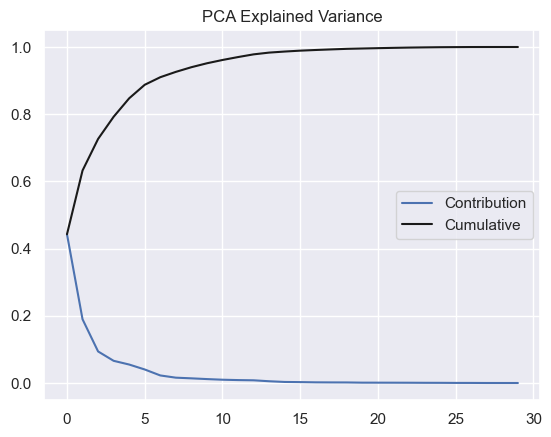

Implementation of PCA


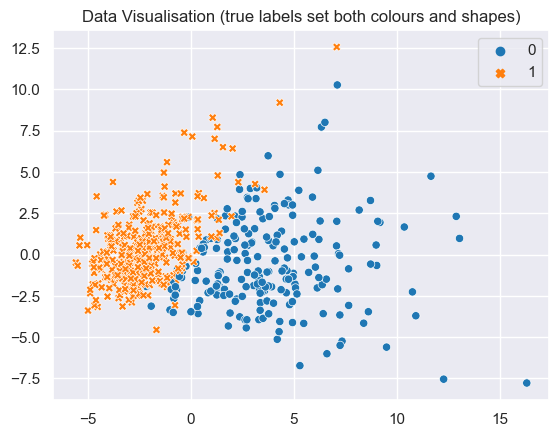

In [19]:
n_comp = 2   # YOUR_CHOICE (though for visualisation 2D is common)

tsne = manifold.TSNE(n_components=n_comp)
mds = manifold.MDS(n_components=n_comp,normalized_stress='auto')
lle = manifold.LocallyLinearEmbedding(n_components=n_comp)
isom = manifold.Isomap(n_components=n_comp)
pca = PCA(n_components=n_comp)
        
# We go to use Iris dataset in first stage        
x, labels = datasets['breast']  # e.g. 'iris', 'breast', 'scadi'

# View data allows you to show a scatterplot of your dataset using only two dimensions of the data
print("Simple visualization using two features")
if labels is not None:
    view_data(x, labels)

# A dendogram. This will not always be appropriate
print("Dendogram visualization")
view_dendrogram(x)  

# Implementation of PCA
print("Getting PCA features")
view_pca(x) 

# Implementation of MDS
print("Implementation of PCA")
visualisation(pca, x, labels) # You can implement another model if you want

### **Clustering**
 
Generic function for clustering. This can be used by many methods (most of the code is just for plotting)

In [49]:
# Define clustering function
def clustering(method, x, labels, plotdimx=0, plotdimy=1):
    # General clustering (note that labels are only used for plotting purposes)
    plabs = method.fit_predict(x)   # this line does all the work!
    # do some plots
    if x.shape[1]>1:
        if labels is not None:
            ax = sns.scatterplot(x=x[:,plotdimx],y=x[:,plotdimy], hue=plabs, size=labels, style=labels, palette=global_palette, legend=None)
            ax.set_title('Colour is based on cluster labels; Size and style are based on ground truth')
        else: # if there are no labels
            ax = sns.scatterplot(x=x[:,0],y=x[:,1], hue=plabs, palette=global_palette, legend=None)
            ax.set_title('Colour is based on cluster labels')
    else:  # for 1D data
        # plt.hist(x,70)
        plt.hist(x[x>-0.5],70)
        plt.show()
        temp_x = x[:,0]
        temp_y = np.random.rand(temp_x.shape[0])
        sns.scatterplot(x=temp_x, y=temp_y, hue=plabs, palette=global_palette, legend=None)
    plt.show()
    return plabs

# Time to play

So, what are we doing here? Below are some generic model options ranging from kmeans to DBScan. Each of these models has their pros and cons and each are designed to cluster data. Keep in mind, that although we do have ground-truth data, these methods aren't necessarily using any kind of supervision. We are evaluating the models using the ground truth (evaluate is used loosely here, it more a visual evaulation) but the ground truth isn't influencing algorithms like K-means or DBScan's method for clustering.

So, by using the pre-written functions below ('clustering') we can test different algorithms with different hyper-parameters on a variety of different datasets. Have fun ^_^

Data and Labels
Clustering


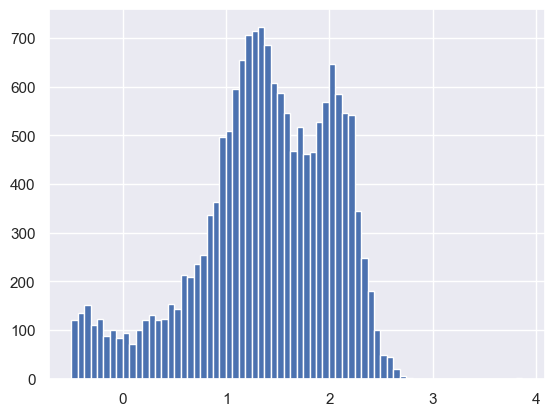

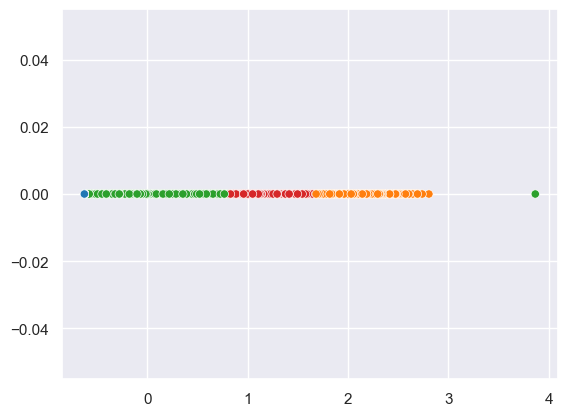

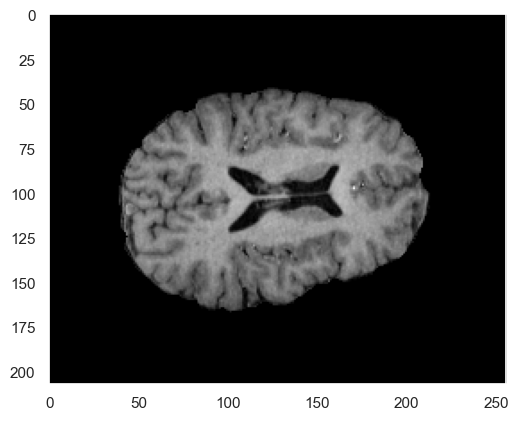

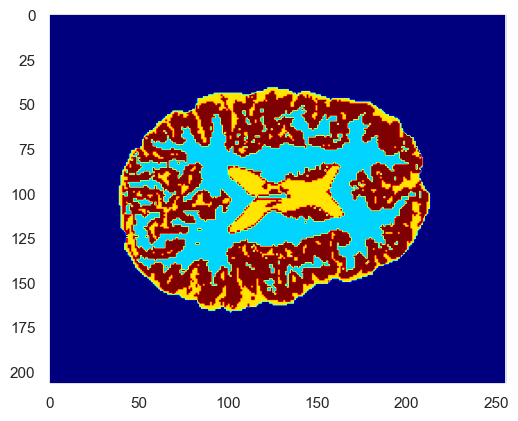

In [50]:
num_clusters = 4  # YOUR_CHOICE (think about the dataset you are using)

kmeans = cluster.KMeans(n_clusters=num_clusters,n_init='auto')
gmm = mixture.GaussianMixture(n_components=num_clusters)
ward = cluster.AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
dbsc = cluster.DBSCAN(eps=5, min_samples=10)  # These are the key parameters to change
spec = cluster.SpectralClustering(n_clusters=num_clusters)


chosen_dataset = 'brain'

x, labels = datasets[chosen_dataset]   # e.g. 'iris', 'breast', 'brain' etc
print("Data and Labels")
if labels is not None:
    view_data(x, labels)

print("Clustering")
plabs = clustering(gmm, x, labels)  # e.g. kmeans, gmm
if chosen_dataset == 'brain':
    view_brain_image(x, plabs, nx, ny)   # only use if you select 'brain' above

### **Ideas for things to do**:

After exploring different visualisation and clustering methods on a range of datasets,
consider exploring some of the following in a group or on your own:

1) results across different datasets using default methods (visualisation and clustering)

2) effect of parameters on particular methods (for a limited number of datasets)

3) stability wrt noise

4) stability wrt dataset size (subsampling)

5) measuring consensus amongst methods

6) measuring "success" wrt labels (when available)

7) try using PCA for dimensionality reduction and feeding the reduced datasets into clustering methods
    